# Project description

A supermarket chain is introducing a computer vision system for processing customer photos. Photofixation at the checkout area will help determine the age of the customers in oder to:<br>
- analyze purchases and offer products that may interest buyers in particular age group<br>
- monitor clerks selling alcohol<br>

<b> The task</b> is to build a model that will determine the approximate age of a person from a photograph.<br>
<b> The goal</b> is to train a convolutional neural network on the GPU platform, using the dataset with photos of people. Get the MAE score for the test set no higher than 8.

## Initialization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Load data

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We built a generator with the ImageDataGenerator generator.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


## EDA

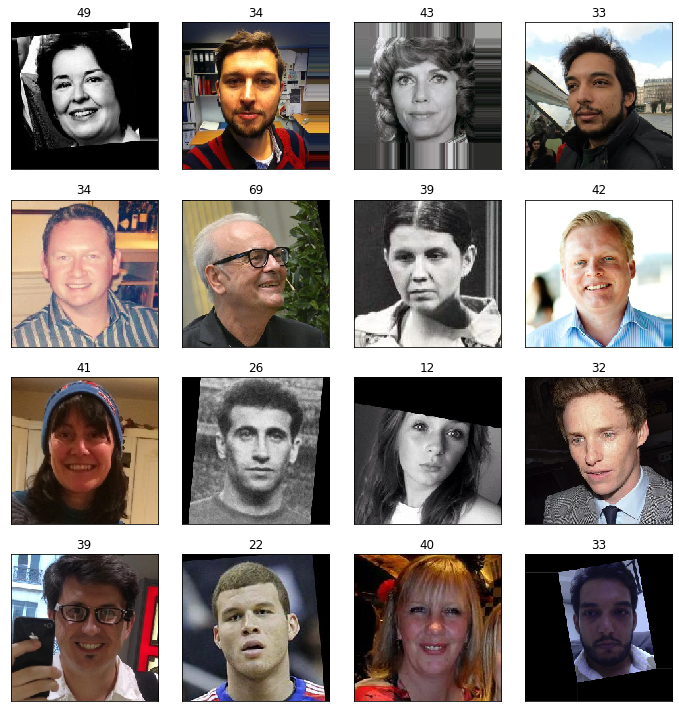

In [9]:
# Printing 16 photos of people in the data set
# Real age of each person is in the title
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

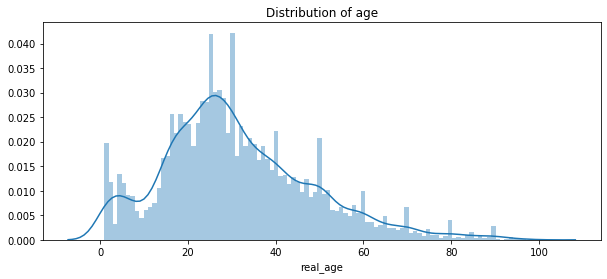

In [10]:
# Making histogram with distribution of ages
plt.figure(figsize=(10,4))
sns.distplot(labels.real_age, kde=True, bins=100)
plt.title("Distribution of age")
plt.show()

### Findings

The average age of the customers in the store is 22-30. We can observe the second peak on the graph close to 0 to 10 years, this is because some customers visit the store with their children.

## Modelling

Running a neural network model requires a lot of computing power so it needs to be done on the GPU platform. Below we will define the necessary functions to train the model on the GPU platform and build a single script containing all of them along with the initialization section.

In [16]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv('/datasets/faces/labels.csv')
 
    datagen = ImageDataGenerator(
        rescale=1./255, 
        validation_split=0.25,
        width_shift_range=0.2,
        height_shift_range=0.2)
 
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory='/datasets/faces/final_files/',
        x_col = "file_name",
        y_col = "real_age",
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345) 
 
    return train_gen_flow

In [17]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv('/datasets/faces/labels.csv')
 
    datagen = ImageDataGenerator(
        rescale=1./255, 
        validation_split=0.25)
 
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory='/datasets/faces/final_files/',
        x_col = "file_name",
        y_col = "real_age",
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345) 
 
    return test_gen_flow

In [18]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(input_shape = input_shape, weights='imagenet', include_top=False)
    #backbone.trainable = False
    model = Sequential()
    optimizer = Adam(lr = 0.0001)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer,loss='mse',metrics=['mae'])
 
    return model

In [19]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=2)

    return model

### Prepare the Script to Run on the GPU Platform

The script below includes the initialization section and it will be run on GPU platform. 

In [20]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

The results of the execution of the script on the GPU platform is as follows:

Epoch 1/10<br>
2021-07-08 14:58:32.922858: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-07-08 14:58:33.201732: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7<br>
356/356 - 94s - loss: 193.3862 - mae: 10.2400 - val_loss: 622.6416 - val_mae: 19.9244<br>
Epoch 2/10<br>
356/356 - 88s - loss: 88.6911 - mae: 7.1926 - val_loss: 185.8460 - val_mae: 10.0332<br>
Epoch 3/10<br>
356/356 - 88s - loss: 68.2759 - mae: 6.3199 - val_loss: 94.6670 - val_mae: 7.2331<br>
Epoch 4/10<br>
356/356 - 88s - loss: 49.7801 - mae: 5.4485 - val_loss: 78.9240 - val_mae: 6.6673<br>
Epoch 5/10<br>
356/356 - 88s - loss: 35.6455 - mae: 4.6385 - val_loss: 94.7679 - val_mae: 7.5467<br>
Epoch 6/10<br>
356/356 - 88s - loss: 29.2851 - mae: 4.1511 - val_loss: 81.9402 - val_mae: 6.7731<br>
Epoch 7/10<br>
356/356 - 88s - loss: 25.3673 - mae: 3.8732 - val_loss: 102.8548 - val_mae: 7.7749<br>
Epoch 8/10<br>
356/356 - 88s - loss: 21.7222 - mae: 3.5756 - val_loss: 80.8563 - val_mae: 6.5781<br>
Epoch 9/10<br>
356/356 - 88s - loss: 20.6968 - mae: 3.5039 - val_loss: 89.6608 - val_mae: 7.1392<br>
Epoch 10/10<br>
356/356 - 88s - loss: 19.0028 - mae: 3.3364 - val_loss: 75.5834 - val_mae: 6.4431<br>

## Conclusions

We trained ResNet50 architecture. On average the model makes a mistake of 6.44, that is actually pretty good and can  be compared to human. The model is not overfitted, since loss and MAE are decreasing both on training and validation sets.